In [4]:
# Import libraries if not already done
import pandas as pd

df = pd.read_csv('../data/MachineLearningRating_v3.txt', sep='|') 
# Load your main dataframe (assuming you have it saved as a CSV or you can load from your data source)
# Example:
# df = pd.read_csv('path_to_your_dataset.csv')

# Create a new 'HasClaim' column: 1 if TotalClaims > 0 else 0
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)

# Now filter policies with claims
df_claims = df[df['HasClaim'] == 1].copy()

print(df_claims.info())
print(df_claims.head())
print(df_claims.isnull().sum())


C:\Users\saron\AppData\Local\Temp\ipykernel_1592\1606722206.py:4: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/MachineLearningRating_v3.txt', sep='|')


<class 'pandas.core.frame.DataFrame'>
Index: 2788 entries, 203 to 999923
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   UnderwrittenCoverID       2788 non-null   int64  
 1   PolicyID                  2788 non-null   int64  
 2   TransactionMonth          2788 non-null   object 
 3   IsVATRegistered           2788 non-null   bool   
 4   Citizenship               2788 non-null   object 
 5   LegalType                 2788 non-null   object 
 6   Title                     2788 non-null   object 
 7   Language                  2788 non-null   object 
 8   Bank                      2571 non-null   object 
 9   AccountType               2710 non-null   object 
 10  MaritalStatus             2773 non-null   object 
 11  Gender                    2774 non-null   object 
 12  Country                   2788 non-null   object 
 13  Province                  2788 non-null   object 
 14  PostalCod

In [5]:
# Drop columns with >50% missing data
cols_to_drop = ['CrossBorder', 'NumberOfVehiclesInFleet']
df_claims.drop(columns=cols_to_drop, inplace=True)

# For CustomValueEstimate (~76% missing), drop or impute? Let's drop for simplicity
df_claims.drop(columns=['CustomValueEstimate'], inplace=True)

# For WrittenOff, Rebuilt, Converted (~67% missing), drop or impute? Drop for now
df_claims.drop(columns=['WrittenOff', 'Rebuilt', 'Converted'], inplace=True)

# For categorical columns with low missingness, fill with 'Unknown'
for col in ['Bank', 'AccountType', 'MaritalStatus', 'Gender']:
    df_claims[col].fillna('Unknown', inplace=True)

# For numeric columns with low missingness, fill with median
for col in ['mmcode', 'Cylinders', 'cubiccapacity', 'kilowatts', 'NumberOfDoors']:
    df_claims[col].fillna(df_claims[col].median(), inplace=True)

# Check again for missing values
print(df_claims.isnull().sum())


UnderwrittenCoverID           0
PolicyID                      0
TransactionMonth              0
IsVATRegistered               0
Citizenship                   0
LegalType                     0
Title                         0
Language                      0
Bank                          0
AccountType                   0
MaritalStatus                 0
Gender                        0
Country                       0
Province                      0
PostalCode                    0
MainCrestaZone                0
SubCrestaZone                 0
ItemType                      0
mmcode                        0
VehicleType                  13
RegistrationYear              0
make                         13
Model                        13
Cylinders                     0
cubiccapacity                 0
kilowatts                     0
bodytype                     13
NumberOfDoors                 0
VehicleIntroDate             13
AlarmImmobiliser              0
TrackingDevice                0
CapitalO

C:\Users\saron\AppData\Local\Temp\ipykernel_1592\3133998453.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_claims[col].fillna('Unknown', inplace=True)
C:\Users\saron\AppData\Local\Temp\ipykernel_1592\3133998453.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [10]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

# Convert TransactionMonth to datetime (coerce errors to NaT)
df_claims['TransactionMonth'] = pd.to_datetime(df_claims['TransactionMonth'], errors='coerce')

# Extract Transaction Year
df_claims['TransactionYear'] = df_claims['TransactionMonth'].dt.year

# Vehicle Age: TransactionYear - RegistrationYear
df_claims['VehicleAge'] = df_claims['TransactionYear'] - df_claims['RegistrationYear']

# TermFrequency numeric mapping
freq_map = {'Monthly': 12, 'Quarterly': 4, 'Half Yearly': 2, 'Annual': 1}
# Make sure TermFrequency exists and handle missing values
if 'TermFrequency' in df_claims.columns:
    df_claims['TermFrequency_num'] = df_claims['TermFrequency'].map(freq_map).fillna(1)
else:
    df_claims['TermFrequency_num'] = 1  # default if missing

# Simplify 'make' by grouping low-frequency categories into 'Other'
make_counts = df_claims['make'].value_counts()
threshold = 20  # makes with less than 20 instances grouped as Other
df_claims['make_simplified'] = df_claims['make'].apply(
    lambda x: x if pd.notna(x) and make_counts.get(x, 0) >= threshold else 'Other'
)

# One-hot encode categorical columns with low cardinality (including TermFrequency)
cat_cols = ['Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Language', 'LegalType', 'Title', 'TermFrequency']
# Only encode those that actually exist to avoid errors
cat_cols_existing = [col for col in cat_cols if col in df_claims.columns]
df_claims = pd.get_dummies(df_claims, columns=cat_cols_existing, drop_first=True)

# Label encode 'make_simplified'
le = LabelEncoder()
df_claims['make_encoded'] = le.fit_transform(df_claims['make_simplified'])

# Drop original 'make' and 'make_simplified'
df_claims.drop(columns=['make', 'make_simplified'], inplace=True)

print(df_claims[['VehicleAge', 'TermFrequency_num', 'make_encoded']].head())


      VehicleAge  TermFrequency_num  make_encoded
203            3                  1             0
284            9                  1             8
1560           1                  1             1
1779           5                  1            10
1943           1                  1             1


In [40]:
# Convert categorical columns to dummy variables (one-hot)
df_encoded = pd.get_dummies(df_claims, drop_first=True)


Linear Regression - RMSE: 36281.2866, R-squared: 0.1815
Random Forest - RMSE: 36774.7801, R-squared: 0.1591
XGBoost - RMSE: 38293.9655, R-squared: 0.0882


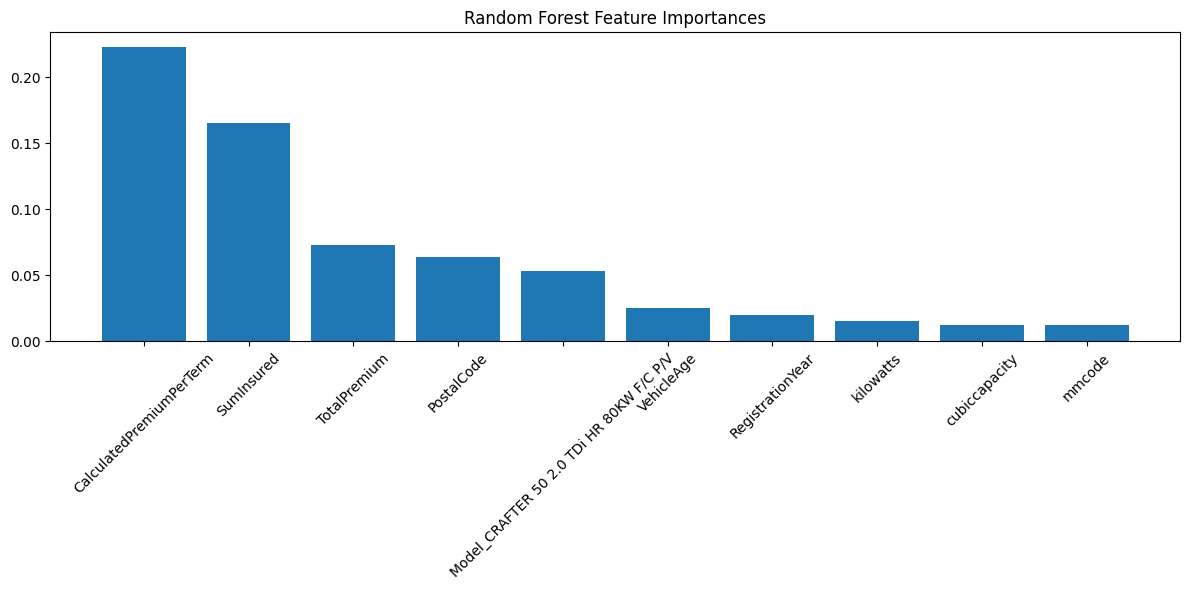

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Prepare dataset for severity prediction (only claims > 0)
df_claims_severity = df_claims[df_claims['TotalClaims'] > 0].copy()

# 2. Define features (drop target and identifiers)
drop_cols = ['TotalClaims', 'PolicyID', 'UnderwrittenCoverID', 'TransactionMonth', 'TransactionYear']
X = df_claims_severity.drop(columns=drop_cols)
y = df_claims_severity['TotalClaims']

# 3. Handle non-numeric columns
# Strip whitespace and replace empty strings with NaN
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].str.strip()
    X[col] = X[col].replace('', np.nan)  # assign back

# Fill NaNs with 'Unknown' for categorical features
X.fillna('Unknown', inplace=True)

# One-hot encode categorical columns (which remain as object)
X = pd.get_dummies(X, drop_first=True)

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Train models

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# XGBoost Regressor
xgb_model = XGBRegressor(random_state=42, n_estimators=100, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 6. Evaluate models

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  # manually compute RMSE
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.4f}, R-squared: {r2:.4f}")

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

# 7. Feature Importance for best model (example with Random Forest)

importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Random Forest Feature Importances")
plt.bar(range(10), importances[indices][:10], align='center')
plt.xticks(range(10), features[indices][:10], rotation=45)
plt.tight_layout()
plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

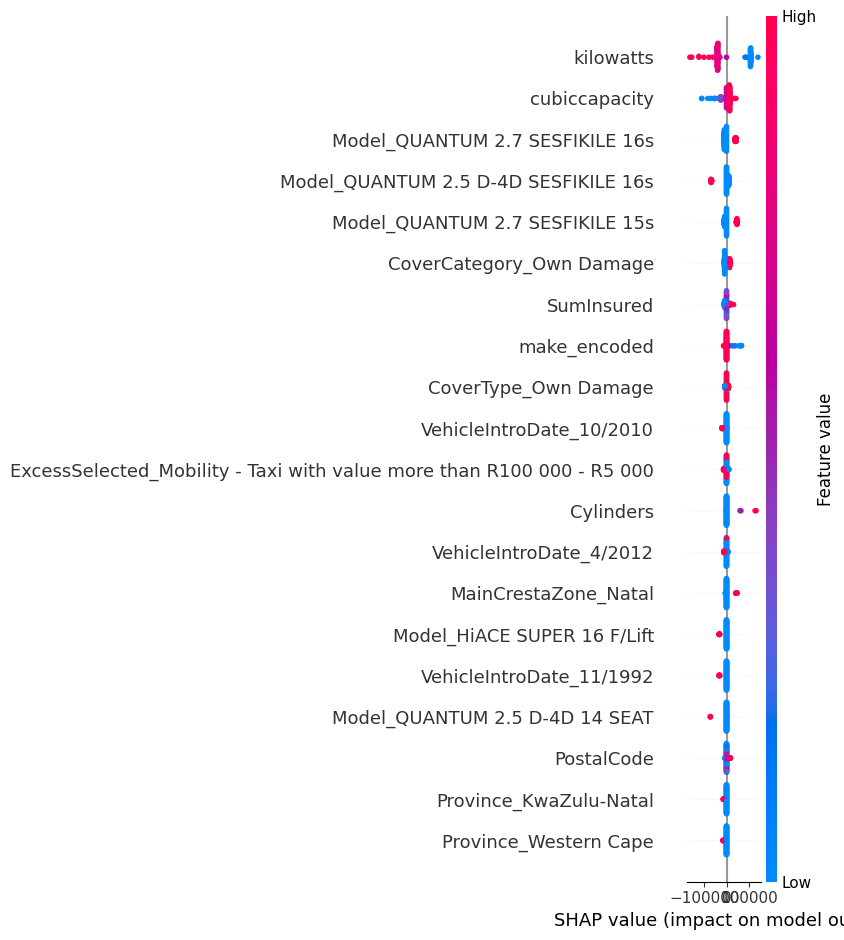

In [18]:
import shap

# For linear regression, use KernelExplainer
explainer = shap.KernelExplainer(lr_model.predict, X_train.sample(100, random_state=42))
shap_values = explainer.shap_values(X_test.sample(100, random_state=42))

# Plot summary
shap.summary_plot(shap_values, X_test.sample(100, random_state=42))


In [3]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop(['TotalClaims'], axis=1)
y = df_encoded['TotalClaims']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


NameError: name 'df_encoded' is not defined

In [45]:
# Find datetime columns in X_train
datetime_cols = X_train.select_dtypes(include=['datetime64[ns]']).columns

# Convert them to numeric (timestamp)
for col in datetime_cols:
    X_train[col] = X_train[col].astype('int64') // 10**9  # convert to seconds since epoch
    X_test[col] = X_test[col].astype('int64') // 10**9


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load data with improved memory handling
df = pd.read_csv('../data/MachineLearningRating_v3.txt', sep='|', low_memory=False)

# Create binary target based on TotalClaims
df['HasClaim'] = (df['TotalClaims'].fillna(0).astype(float) > 0).astype(int)

# Drop non-predictive or leak-prone columns (optional, but helpful)
drop_cols = ['TotalClaims', 'PolicyID', 'UnderwrittenCoverID', 'TransactionMonth']
X = df.drop(columns=drop_cols + ['HasClaim'], errors='ignore')
y = df['HasClaim']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Encode categorical variables
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align columns between train/test
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Initialize classifier with performance-conscious params
model = RandomForestClassifier(
    n_estimators=100,  # reduce this if slow
    max_depth=15,      # limit depth to prevent overfitting and improve speed
    random_state=42,
    n_jobs=-1          # use all cores
)

print("Starting model training...")
model.fit(X_train, y_train)
print("Training completed. Predicting...")

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Starting model training...
Training completed. Predicting...
Accuracy: 0.9972102789721028
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199462
           1       0.00      0.00      0.00       558

    accuracy                           1.00    200020
   macro avg       0.50      0.50      0.50    200020
weighted avg       0.99      1.00      1.00    200020



C:\Users\saron\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\saron\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\saron\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [2]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)


In [3]:
import sklearn
import imblearn
print("scikit-learn:", sklearn.__version__)
print("imblearn:", imblearn.__version__)


scikit-learn: 1.4.2
imblearn: 0.12.2


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
model.fit(X_resampled, y_resampled)
